In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from urllib.request import urlopen
import json
import folium
from folium import plugins
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from fbprophet import Prophet
from pandas import to_datetime
import datetime
import numpy 
from IPython.display import display, HTML
import sqlite3
from sqlite3 import Error

In [2]:
### Utility Functions

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
# Delete old database file
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db=True)

In [4]:
# Functions To Insert Into Tables

def insert_project_details(conn,values):
    sql = """ INSERT INTO ProjectDetails VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_project(conn,values):
    sql = """ INSERT INTO Project VALUES(?,?,?,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_location(conn,values):
    sql = """ INSERT INTO ProjectLocation VALUES(NULL,?,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_inverter(conn,values):
    sql = """ INSERT INTO InverterDetails VALUES(NULL,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_pvmodule(conn,values):
    sql = """ INSERT INTO PVModuleDetails VALUES(NULL,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_project_timeline(conn,values):
    sql = """ INSERT INTO ProjectTimeline VALUES(NULL,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_project_cost_info(conn,values):
    sql = """ INSERT INTO ProjectCost VALUES(NULL,?,?,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_project_production_info(conn,values):
    sql = """ INSERT INTO ProjectProd VALUES(NULL,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

In [5]:
# Function To Read The Csv File One Character At A Time

def readCSV(file):
    c = file.read(1)
    if not c:
        return None
    parts = []
    current = ''
    while True:
        if not c or c == "\n":
            parts.append(current)
            return parts
        elif c == ',':
            parts.append(current)
            current = ''
        elif c == '"':
            c = file.read(1)
            while c != '"':
                current = current + c ;
                c = file.read(1)
                if not c or c == '"':
                    break
        else:
            current = current + c
        c = file.read(1)

In [6]:
# Cleansing City Data
def cleanse(city):
    digit_checker = any(chr.isdigit() for chr in city)
    
    city = city.lower()
    
    if city.endswith(','):
        city = city.replace(',','')
    
    if city.endswith(' '):
        city = city.replace(' ','')
        
    if ',' in city:
        city_modified = re.search("^([a-z]*).*$",city)
        city_modified = str(city_modified.group(1))
        city = city.replace(city,city_modified)
    
    if digit_checker == True:
        city = ''
        
    if city == "Bardinia":
        city = city.replace('Bardinia','Bardonia')
        
    if city == 'cabria hgts':
        city = city.replace('cabria hgts','cambria heights')
        
    if city == 'jackson hgts ny':
        city = city.replace('jackson hgts ny','jackson heights')
        
    if ' hts' in city:
        city = city.replace(' hts',' heights')
        
    if ' hgts' in city:
        city = city.replace(' hgts',' heights')
    
    return city.title()

In [7]:
# Diff of DtAppReceived and DtCompleted
def days(start_date, end_date):
    if start_date=='Others' or end_date=='Others':
        return -1
    if start_date=='' or end_date=='':
        return -1
    mdate1 = datetime.datetime.strptime(start_date, "%m/%d/%Y").date()
    rdate1 = datetime.datetime.strptime(end_date, "%m/%d/%Y").date()
    return abs((rdate1 - mdate1).days)

In [8]:
### Utility Functions for result fetching from database
def fetchResult(sql_statement):
    normalized_database_filename = 'normalized.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df = pd.read_sql_query(sql_statement, conn)
    return df

In [9]:
# Creating a dictionary to load the data into the table columns and dealing with missing Data.
def asSolarInfo(row):
    
    loc_coor = row[30]
    loc_coor_modified = re.search("[^(]*([+-]?\d+\.\d+, *[+-]?\d+.\d+)", loc_coor)
    loc_coor_modified = "(" + loc_coor_modified.group(0) + ")"
    if loc_coor_modified == '':
        loc_coor_modified = loc_coor_modified.replace('','Others')
    
    city = cleanse(row[3])
    if city == '':
        city = city.replace('','Others')
    
    if row[18] == '': 
#         row[18] = row[18].replace('','0')                USED FOR FINDING THE MEAN OF INVERTER QUANTITY
        row[18] = row[18].replace('','9')
    total_inverter_quantity = int(row[18])
    
    if row[21] == '':
#         row[21] = row[21].replace('','0')                USED FOR FINDING THE MEAN OF PV MODULE
        row[21] = row[21].replace('','94')
    total_pv_module_quantity = int(row[21])
    
    if row[22] == '':
#         row[22] = row[22].replace('','0')                USED FOR FINDING THE MEAN OF PROJECT COST
        row[22] = row[22].replace('','78897.97')
    project_cost = float(row[22])
    
    if row[23] == '':
#         row[23] = row[23].replace('','0')                USED FOR FINDING THE MEAN OF INCENTIVE
        row[23] = row[23].replace('','15436.73')
    incentive = float(row[23])
    
    if row[24] == '':
#         row[24] = row[24].replace('','0')                USED FOR FINDING THE MEAN OF NAMEPLATE KW DC
        row[24] = row[24].replace('','33.97')
    total_nameplate_kw_dc = float(row[24])
    
    if row[25] == '':
#         row[25] = row[25].replace('','0')                USED FOR FINDING THE MEAN OF EXPECTED KW ANNUAL PRODUCTION
        row[25] = row[25].replace('','39841.47')
    expected_kwh_annual_production = float(row[25])
    
    if row[0] == '':
        row[0] = row[0].replace('','Others')
        
    if row[1] == '':
        row[1] = row[1].replace('','Others')
        
    if row[4] == '':
        row[4] = row[4].replace('','Others')
        
    if row[6] == '':
        row[6] = row[6].replace('','Others')
        
    if row[7] == '':
        row[7] = row[7].replace('','Others')
        
    if row[8] == '':
        row[8] = row[8].replace('','Others')
        
    if row[9] == '':
        row[9] = row[9].replace('','Others')
    
    if row[10] == '':
        row[10] = row[10].replace('','Others')
        
    if row[11] == '':
        row[11] = row[11].replace('','Others')
        
    if row[14] == '':
        row[14] = row[14].replace('','Others')
        
    if row[15] == '':
        row[15] = row[15].replace('','Others')
        
    if row[16] == '':
        row[16] = row[16].replace('','Others')
        
    if row[17] == '':
        row[17] = row[17].replace('','Others')
        
    if row[19] == '':
        row[19] = row[19].replace('','Others')
        
    if row[20] == '':
        row[20] = row[20].replace('','Others')
        
    if row[26] == '':
        row[26] = row[26].replace('','Others')
        
    if row[27] == '':
        row[27] = row[27].replace('','Others')
        
    if row[28] == '':
        row[28] = row[28].replace('','Others')
        
    if row[29] == '':
        row[29] = row[29].replace('','Others')
        
    
    solar_details_dict = {'reporting_period':row[0],'project_id':row[1],'city':city,
                     'county':row[4],'state':row[5],'zip_code':row[6],'sector':row[7],'program_type':row[8],
                     'solicitation':row[9],'electric_utility':row[10],'purchase_type':row[11],
                     'date_application_recieved':row[12],'date_completed':row[13],
                     'project_status':row[14],'contractor':row[15],
                     'primary_inverter_manufacturer':row[16],
                     'primary_inverter_model_number':row[17],'total_inverter_quantity':row[18],
                     'primary_pv_module_manufacturer':row[19],
                     'pv_module_model_number':row[20],'total_pv_module_quantity':row[21],
                     'project_cost':row[22],'incentive':row[23],'total_nameplate_kw_dc':row[24],
                     'expected_kwh_annual_production':row[25],'remote_net_metering':row[26],
                     'affordable_solar':row[27],'community_distributed_generation':row[28],
                     'green_jobs_green_ny_participants':row[29],'loc_coordinates':loc_coor_modified}
    return solar_details_dict

In [10]:
# CREATING THE NON-NORMALIZED DATABASE

def non_normalized_db(data_filename, normalized_database_filename):
    first = True
    reporting_period_list = []
    project_id_list = []
    city_list = []
    county_list = []
    state = []
    zip_code_list = []
    sector_list = []
    program_type_list = []
    solicitation_list = []
    electric_utility_list = []
    purchase_type_list = []
    date_application_recieved_list = []
    date_completed_list = []
    days_list = []
    project_status_list = []
    contractor_list = []
    inverter_manufacturer_list = []
    inverter_model_no_list = []
    total_inverter_quantity_list = []
    pv_module_manufacturer_list = []
    pv_module_model_number_list = []
    total_pv_module_quantity_list = []
    project_cost_list = []
    incentive_list = []
    total_nameplate_kw_dc_list = []
    expected_kwh_annual_production_list = []
    remote_net_metering_list = []
    affordable_solar_list = []
    community_distributed_generation_list = []
    green_jobs_green_ny_participants_list = []
    loc_coordinates_list = []
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            reporting_period_list.append(info['reporting_period'])
            project_id_list.append(info['project_id'])
            city_list.append(info['city'])
            county_list.append(info['county'])
            state.append(info['state'])
            zip_code_list.append(info['zip_code'])
            sector_list.append(info['sector'])
            program_type_list.append(info['program_type'])
            solicitation_list.append(info['solicitation'])
            electric_utility_list.append(info['electric_utility'])
            purchase_type_list.append(info['purchase_type'])
            date_application_recieved_list.append(info['date_application_recieved'])
            date_completed_list.append(info['date_completed'])
            project_status_list.append(info['project_status'])
            contractor_list.append(info['contractor'])
            inverter_manufacturer_list.append(info['primary_inverter_manufacturer'])
            inverter_model_no_list.append(info['primary_inverter_model_number'])
            total_inverter_quantity_list.append(info['total_inverter_quantity'])
            pv_module_manufacturer_list.append(info['primary_pv_module_manufacturer'])
            pv_module_model_number_list.append(info['pv_module_model_number'])
            total_pv_module_quantity_list.append(info['total_pv_module_quantity'])
            project_cost_list.append(info['project_cost'])
            incentive_list.append(info['incentive'])
            total_nameplate_kw_dc_list.append(info['total_nameplate_kw_dc'])
            expected_kwh_annual_production_list.append(info['expected_kwh_annual_production'])
            remote_net_metering_list.append(info['remote_net_metering'])
            affordable_solar_list.append(info['affordable_solar'])
            community_distributed_generation_list.append(info['community_distributed_generation'])
            green_jobs_green_ny_participants_list.append(info['green_jobs_green_ny_participants'])
            loc_coordinates_list.append(info['loc_coordinates'])
        
    solar_project_details = zip(reporting_period_list,project_id_list,city_list,county_list,
                                state,zip_code_list,sector_list,program_type_list,
                                solicitation_list,electric_utility_list,purchase_type_list,
                                date_application_recieved_list,date_completed_list,
                                project_status_list,contractor_list,
                                inverter_manufacturer_list,inverter_model_no_list,
                                total_inverter_quantity_list,pv_module_manufacturer_list,
                                pv_module_model_number_list,total_pv_module_quantity_list,
                                project_cost_list,incentive_list,total_nameplate_kw_dc_list,
                                expected_kwh_annual_production_list,remote_net_metering_list,
                                affordable_solar_list,community_distributed_generation_list,
                                green_jobs_green_ny_participants_list,loc_coordinates_list)
    
    # MEAN FOR INVERTER QUANTITY
    # total_inverters = sum(total_inverter_quantity_list)
    # print(total_inverters)
    # total_inverter_quantity_list_len = len(total_inverter_quantity_list)
    # print(total_inverter_quantity_list_len)
    # mean_inverter_quantity = round(total_inverters/total_inverter_quantity_list_len)
    # print(mean_inverter_quantity)
    
    # MEAN FOR PV MODULE QUANTITY
    # total_pv_modules = sum(total_pv_module_quantity_list)
    # print(total_pv_modules)
    # total_pv_module_quantity_list_len = len(total_pv_module_quantity_list)
    # print(total_pv_module_quantity_list_len)
    # mean_pv_module_quantity = round(total_pv_modules/total_pv_module_quantity_list_len)
    # print(mean_pv_module_quantity)
    
    # MEAN FOR PROJECT COST
    # project_costs = sum(project_cost_list)
    # print(project_costs)
    # project_cost_list_len = len(project_cost_list)
    # print(project_cost_list_len)
    # mean_project_cost = round(project_costs/project_cost_list_len,2)
    # print(mean_project_cost)
    
    # MEAN FOR INCENTIVES
    # incentives = sum(incentive_list)
    # print(incentives)
    # incentive_list_len = len(incentive_list)
    # print(incentive_list_len)
    # mean_incentive = round(incentives/incentive_list_len,2)
    # print(mean_incentive)
    
    # MEAN FOR TOTAL NAMEPLATE KW DC
    # total_nameplate_kw_dcs = sum(total_nameplate_kw_dc_list)
    # print(total_nameplate_kw_dcs)
    # total_nameplate_kw_dc_list_len = len(total_nameplate_kw_dc_list)
    # print(total_nameplate_kw_dc_list_len)
    # mean_total_nameplate_kw_dc = round(total_nameplate_kw_dcs/total_nameplate_kw_dc_list_len,2)
    # print(mean_total_nameplate_kw_dc)
    
    # MEAN FOR EXPECTED ANNUAL PRODUCTIONS
    # expected_kwh_annual_productions = sum(expected_kwh_annual_production_list)
    # print(expected_kwh_annual_productions)
    # expected_kwh_annual_production_list_len = len(expected_kwh_annual_production_list)
    # print(expected_kwh_annual_production_list_len)
    # mean_expected_kwh_annual_production = round(expected_kwh_annual_productions/expected_kwh_annual_production_list_len,2)
    # print(mean_expected_kwh_annual_production)
        
    project_details_table = """CREATE TABLE ProjectDetails
    ([ReportingPeriod] TEXT,
    [ProjectID] TEXT PRIMARY KEY, 
    [City] TEXT,
    [County] TEXT,
    [State] TEXT,
    [ZipCode] TEXT,
    [Sector] TEXT,
    [ProgramType] TEXT,
    [Solicitation] TEXT,
    [ElectricUtility] TEXT,
    [PurchaseType] TEXT,
    [DateRecieved] TEXT,
    [DateCompleted] TEXT,
    [ProjectStatus] TEXT,
    [Contractor] TEXT,
    [InverterManufacturer] TEXT,
    [InverterModelNumber] TEXT,
    [TotalInverterQuantity] INTEGER,
    [PvModuleManufacturer] TEXT,
    [PvModuleModelNumber] TEXT,
    [TotalPvModuleQuantity] INTEGER,
    [ProjectCost] REAL,
    [Incentive] REAL,
    [TotalNameplateKwDc] REAL,
    [ExpectedKwhAnnualProduction] REAL,
    [RemoteNetMetering] TEXT,
    [AffordableSolar] TEXT,
    [CommunityDistrbutedGeneration] TEXT,
    [GreenJobsParticipants] TEXT,
    [LocCoordinates] TEXT
    );"""
    create_table(conn, project_details_table,True)
    insert_project_details(conn,solar_project_details)
    conn.commit()

In [11]:
#Verifying the table creation & insertion of Non-Normalized DB
data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
non_normalized_db(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectDetails""", conn)

In [12]:
# Creating the Project Table
## Dataframe ColumnName	Column Name in DB Table
'''
Project Number(Common)	1(ProjectID)[Primary Key]
Sector	7(Sector)
Program Type	8(Program Type)
Solicitation	9(Solicitation)
Electric Utility	10(Electric Utility)
Purchase Type	11(PurchaseType)
Project Status	14(Project Status)
Contractor	15(Contractor)
'''
def create_project_table(data_filename,normalized_database_filename):
    first = True
    project_id_list = []
    sector_list = []
    program_type_list = []
    solicitation_list = []
    electric_utility_list = []
    purchase_type_list = []
    project_status_list = []
    contractor_list = []
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            project_id_list.append(info['project_id'])
            sector_list.append(info['sector'])
            program_type_list.append(info['program_type'])
            electric_utility_list.append(info['electric_utility'])
            purchase_type_list.append(info['purchase_type'])
            project_status_list.append(info['project_status'])
            contractor_list.append(info['contractor'])
            
    project_table = """CREATE TABLE Project
    ([ProjectID] TEXT NOT NULL PRIMARY KEY,
    [Sector] TEXT,
    [Program Type] TEXT,
    [ElectricUtility] TEXT,
    [PurchaseType] TEXT,
    [ProjectStatus] TEXT,
    [Contractor] TEXT,
    UNIQUE(ProjectID));"""
    
    project_details = zip(project_id_list,sector_list,program_type_list,electric_utility_list,
                          purchase_type_list,project_status_list,contractor_list)
    
    
    create_table(conn, project_table,'Project')
    insert_project(conn,project_details)
    conn.commit()

In [13]:
# Verifying the table creation & insertion of Project
data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_project_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Project""", conn)

In [14]:
# Creating the ProjectLocation Table
## Dataframe ColumnName	Column Name in DB Table
'''
ProjectLocationID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
City	3(City)
County	4(County)
Zip Code	6(Zip Code)
Location	31(Location 1)
'''

def create_project_location_table(data_filename, normalized_database_filename):
    first = True
    project_id_list = []
    city_list = []
    county_list = []
    zip_code_list = []
    location_list = []
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            city = cleanse(info['city'])
            project_id_list.append(info['project_id'])
            city_list.append(city)
            county_list.append(info['county'])
            zip_code_list.append(info['zip_code'])
            location_list.append(info['loc_coordinates'])

    location_details = zip(project_id_list,city_list,county_list,zip_code_list,location_list)
    
                
    project_location_table = """create table ProjectLocation
    ([ProjectLocationID] INTEGER NOT NULL PRIMARY KEY,
    [ProjectID] TEXT NOT NULL,
    [City] TEXT,
    [County] TEXT,
    [ZipCode] TEXT NOT NULL,
    [Location] TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID),
    UNIQUE(ProjectLocationID)
    );"""
    
    create_table(conn, project_location_table,'ProjectLocation')
    insert_location(conn,location_details)
    conn.commit()
                

In [15]:
# Verifying the table creation & insertion of ProjectLocation

data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_project_location_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectLocation order by City""", conn)

In [16]:
# Creating the InverterDetails Table
## Dataframe ColumnName	Column Name in DB Table
'''
InverterDetailsID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Primary Inverter Manufacturer	16(PriInvetMft)
Total Inverter Quantity	18(TotalInvtQt)
'''
def create_inverter_details_table(data_filename, normalized_database_filename):
    first = True
    project_id_list = []
    PriInvetMft_list = []
    TotalInvtQt_list = []
    
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            project_id_list.append(info['project_id'])
            PriInvetMft_list.append(info['primary_inverter_manufacturer'])
            TotalInvtQt_list.append(info['total_inverter_quantity'])
            
    inverter_details = zip(project_id_list,PriInvetMft_list,TotalInvtQt_list)
    
    inverter_details_table = """CREATE TABLE InverterDetails
    ([InverterDetailsID] INTEGER NOT NULL PRIMARY KEY, 
    [ProjectID] TEXT NOT NULL,
    [PriInvetMft] TEXT, 
    [TotalInvtQt] INTEGER,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID),
    UNIQUE(InverterDetailsID));"""
    
    create_table(conn, inverter_details_table,'InverterDetails')
    insert_inverter(conn,inverter_details)
    conn.commit()   

In [17]:
# Verifying the table creation & insertion of InverterDetails
data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_inverter_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM  InverterDetails""", conn)

In [18]:
# Creating the PVModuleDetails Table
## Dataframe ColumnName	Column Name in DB Table
'''
PVModuleDetailsID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Primary PV Module Manufacturer	19(PriPVMft)
Total PV Module Quantity	21(TotalPVQt)
'''

def create_pvmodule_details_table(data_filename, normalized_database_filename):
    first = True
    project_id_list = []
    PriPVMft_list = []
    TotalPVQt_list = []
    
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            project_id_list.append(info['project_id'])
            PriPVMft_list.append(info['primary_pv_module_manufacturer'])
            TotalPVQt_list.append(info['total_pv_module_quantity'])
            
    pvmodule_details = zip(project_id_list,PriPVMft_list,TotalPVQt_list)
    
    pvmodule_table = """CREATE TABLE PVModuleDetails
    ([PVModuleDetailsID] INTEGER NOT NULL PRIMARY KEY, 
    [ProjectID] TEXT NOT NULL,
    [PriPVMft] TEXT,
    [TotalPVQt] INTEGER, 
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID),
    UNIQUE(PVModuleDetailsID));"""

    create_table(conn,pvmodule_table,'PVModuleDetails')
    insert_pvmodule(conn,pvmodule_details)
    conn.commit()

In [19]:
# Verifying the table creation & insertion of PVModuleDetails

data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_pvmodule_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM  PVModuleDetails""", conn)

In [20]:
# Creating the ProjectTimeline Table
## Dataframe ColumnName	Column Name in DB Table
'''
ProjectTimelineID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Date Application Received	11(DtAppReceived)
Date Completed	12(DtCompleted)
TotalDays	Generated Feature(TotalDays)
'''

def create_project_timeline_table(data_filename, normalized_database_filename):
    first = True
    days_list = []
    project_id_list = []
    DtAppReceived_list = []
    DtCompleted_list = []
    
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            total_days = days(info['date_application_recieved'],info['date_completed'])
            if total_days == -1:
                total_days = ''
            days_list.append(total_days)
            project_id_list.append(info['project_id'])
            DtAppReceived_list.append(info['date_application_recieved'])
            DtCompleted_list.append(info['date_completed'])
            
    project_timeline_details = zip(project_id_list,DtAppReceived_list,DtCompleted_list,days_list)
    
    project_timeline_table = """CREATE TABLE ProjectTimeline
    ([ProjectTimelineID] INTEGER NOT NULL PRIMARY KEY,
    [ProjectID] TEXT NOT NULL,
    [DtAppReceived] TEXT,
    [DtCompleted] TEXT,
    [TotalDays] REAL,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID),
    UNIQUE(ProjectTimelineID));"""
    
    create_table(conn,project_timeline_table,'ProjectTimeline')
    insert_project_timeline(conn,project_timeline_details)
    conn.commit()

In [21]:
# Verifying the table creation & insertion of ProjectTimeline

data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_project_timeline_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM  ProjectTimeline""", conn)


In [22]:
# Creating the ProjectCost Table
## Dataframe ColumnName	Column Name in DB Table
'''
ProjectCostID	Primary Key
Project Number(Common)	1(ProjectID)[Foreign Key]
Project Cost	22(ProjectCost)
$Incentive	23(Incentive)
Remote Net Metering	26(RemNetMet)
Affordable Solar	27(AffSolar)
Green Jobs Green New York Participant	29(GreenCertified)
'''

def create_project_cost_table(data_filename, normalized_database_filename):
    first = True
    project_id_list = []
    project_cost_list = []
    incentive_list = []
    RemNetMet_list = []
    AffSolar_list = []
    GreenCertified_list = []
    
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            project_id_list.append(info['project_id'])
            project_cost_list.append(info['project_cost'])
            incentive_list.append(info['incentive'])
            RemNetMet_list.append(info['remote_net_metering'])
            AffSolar_list.append(info['affordable_solar'])
            GreenCertified_list.append(info['green_jobs_green_ny_participants'])
            
    project_cost_details = zip(project_id_list,project_cost_list,incentive_list,RemNetMet_list,
                               AffSolar_list,GreenCertified_list)
    
    project_cost_table = """CREATE TABLE ProjectCost
    ([ProjectCostID] INTEGER NOT NULL PRIMARY KEY,
    [ProjectID] TEXT NOT NULL,
    [ProjectCost] REAL,
    [Incentive] REAL,
    [RemNetMet] TEXT,
    [AffSolar] TEXT,
    [GreenCertified] TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID),
    UNIQUE(ProjectCostID));"""
    
    create_table(conn,project_cost_table,'ProjectCost')
    insert_project_cost_info(conn,project_cost_details)
    conn.commit()

In [23]:
# Verifying the table creation & insertion of ProjectCost
data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_project_cost_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM  ProjectCost""", conn)

In [24]:
# Creating the ProjectProd Table

def create_project_prod_table(data_filename, normalized_database_filename):
    first = True
    project_id_list = []
    TotNamePlateKWDC_list = []
    ExpectKWhAnnProd_list = []
    CommDistGener_list = []
    
    with open(data_filename) as file:
        
        while True:
            row = readCSV(file)
            if first:
                    first = False
                    continue
            if not row:
                break
            info = asSolarInfo(row)
            project_id_list.append(info['project_id'])
            TotNamePlateKWDC_list.append(info['total_nameplate_kw_dc'])
            ExpectKWhAnnProd_list.append(info['expected_kwh_annual_production'])
            CommDistGener_list.append(info['community_distributed_generation'])
            
    project_producation_details = zip(project_id_list,TotNamePlateKWDC_list,ExpectKWhAnnProd_list,
                                      CommDistGener_list)
    
    project_production_table = """CREATE TABLE ProjectProd
    ([ProjectProdID] INTEGER NOT NULL PRIMARY KEY,
    [ProjectID] TEXT NOT NULL,
    [TotNamePlateKWDC] REAL, 
    [ExpectKWhAnnProd] REAL,
    [CommDistGener] TEXT,
    FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID),
    UNIQUE(ProjectProdID));"""
    
    create_table(conn,project_production_table,'ProjectProd')
    insert_project_production_info(conn,project_producation_details)
    conn.commit()

In [25]:
# Verifying the table creation & insertion of ProjectProd
data_filename = 'solar.csv'
normalized_database_filename = 'normalized.db'
create_project_prod_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM  ProjectProd""", conn)

In [26]:
#Plotting Code 

In [27]:
# Converting County Code to FIPS Code for Populating the Choropleth Map
def county_to_3_digit_fips_code(df_counties_fips):  
    ll_counties_fips=[]
    for ele in df_counties_fips.iterrows():
        num=str(ele[1][0])
        ll_counties_fips.append((num,ele[1][1]))
    return ll_counties_fips

def df_county_to_fips_code(df, ll_counties_fips):
    df[pd.isnull(df['County'])]
    ll_df_fips=[]
    for ele in df['County']:
        flag=0
        for i in range(len(ll_counties_fips)):
            #ele=str(ele)
            if type(ele)==float:
                ele=str(ele)
                ele=ele.strip()
            ele=ele.replace('.','')
            if ele==ll_counties_fips[i][1]:
                #print(type(ll[i][1]))
                ll_df_fips.append(ll_counties_fips[i][0])
                flag=1
        if flag==0:
            ll_df_fips.append('125')
    return ll_df_fips

def year_filtered_dataframe(col,table,year):
    sql_statement="""select County, pt.DtAppReceived, {0} from 
            ProjectTimeline AS pt 
            INNER JOIN 
            {1} AS pd
            on pt.ProjectID=pd.ProjectID
            INNER JOIN 
            ProjectLocation AS pl
            on pt.ProjectID=pl.ProjectID
            where cast(substr(pt.DtAppReceived,length(pt.DtAppReceived)-3,4) as INTEGER)<={2}"""
    sql_statement = sql_statement.format(col,table,year)
    normalized_database_filename = 'normalized.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df_yr = pd.read_sql_query(sql_statement, conn)
    df_yr = df_yr.dropna()
    df_yr = df_yr.replace('','0')
    df_yr[col]= df_yr[col].astype(float) 
    return df_yr

In [28]:
def df_year_filtered(col,table,year):
    #Filtering the year wise data
    df_year = year_filtered_dataframe(col,table,year)
    return df_year

def ll_counties_fips():
    #Reading the dataframes for the solar and counties
    #df['Expected KWh Annual Production']=df['Expected KWh Annual Production'].replace(np.nan,0)
    df_counties_fips = pd.read_csv('Counties.csv',error_bad_lines=False)

    #Converting the county to 3 digit fips code
    ll_counties_fips = county_to_3_digit_fips_code(df_counties_fips)
    return ll_counties_fips

def ll_df_fips(df, ll_counties_fips):
    #Adding the fips code of all the counties in the dataframe
    ll_df_fips = df_county_to_fips_code(df,ll_counties_fips)
    return ll_df_fips

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

yr=int(input("Enter year:"))
col=str(input("Enter column:"))
table=str(input("Enter table:"))
for year in range(yr,yr+1): 
    df_fips_expectedAnnProdKwh=pd.DataFrame()
    df_year=df_year_filtered(col,table,year)
    ll=ll_counties_fips()
    ll2=ll_df_fips(df_year, ll)

    df_fips_expectedAnnProdKwh['solarprod']=df_year[col]

    df_fips_expectedAnnProdKwh['fips']=ll2
    df_fips_expectedAnnProdKwh['sum_kwh_prod']=df_fips_expectedAnnProdKwh.groupby('fips').transform('sum')
    df_fips_expectedAnnProdKwh=df_fips_expectedAnnProdKwh.sort_values(by=['fips'])
    df_fips_expectedAnnProdKwh=df_fips_expectedAnnProdKwh.drop(['solarprod'],axis=1)
    
    #Using Choropleth
    fig = px.choropleth(df_fips_expectedAnnProdKwh, geojson=counties, locations='fips', color='sum_kwh_prod',
                           color_continuous_scale="Viridis",
                           range_color=(0, max(df_fips_expectedAnnProdKwh['sum_kwh_prod'])),
                           scope="usa",
                           labels={'sum_kwh_prod':col}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

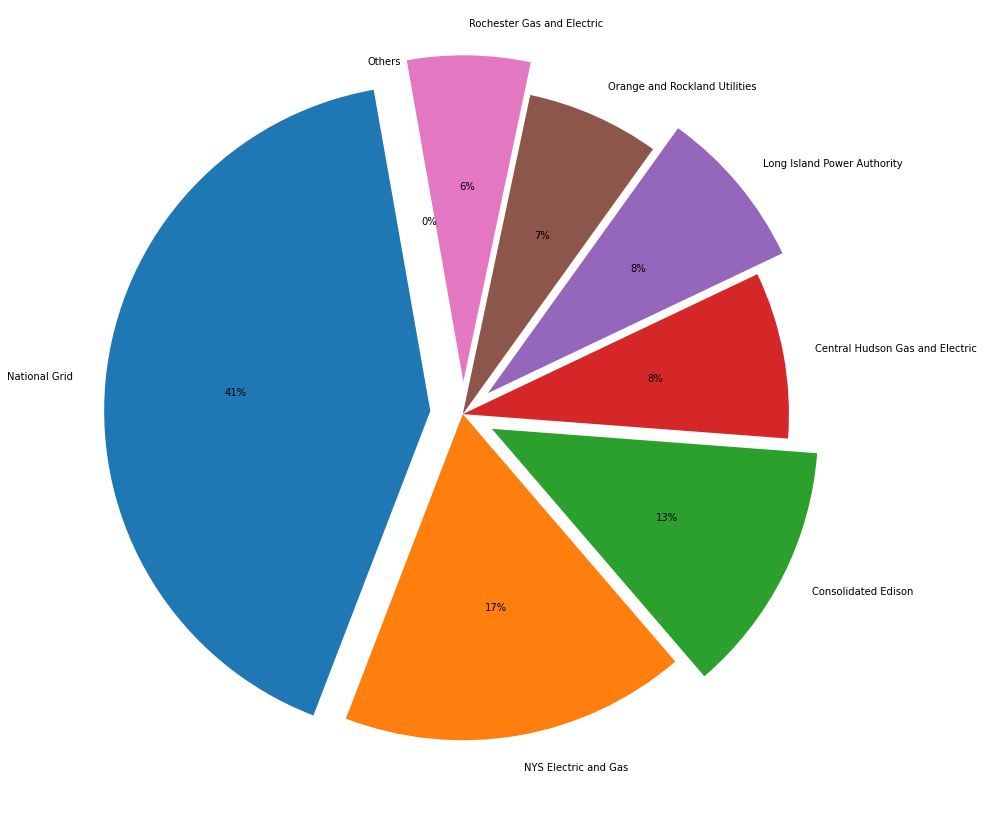

In [30]:
# Electric Utility proportion in Total Name Plate Kwh DC
sql_statement = """SELECT ElectricUtility AS eu,
    SUM(TotNamePlateKWDC) AS DC_Capacity
    FROM Project INNER JOIN PROJECTPROD
    ON PROJECT.PROJECTID=PROJECTPROD.PROJECTID
    GROUP BY eu ORDER  BY DC_Capacity DESC"""

df_ElecUtil=fetchResult(sql_statement)
fig = plt.figure(figsize=(15,15))
separated=(.1,0,0.1,0,0.1,0,0.1,0)
plt.pie(df_ElecUtil['DC_Capacity'].tolist(), labels=df_ElecUtil["eu"],
        autopct='%1.0f%%', shadow=False, startangle=100,explode=separated)
plt.rcParams['font.size'] = 20
plt.show()

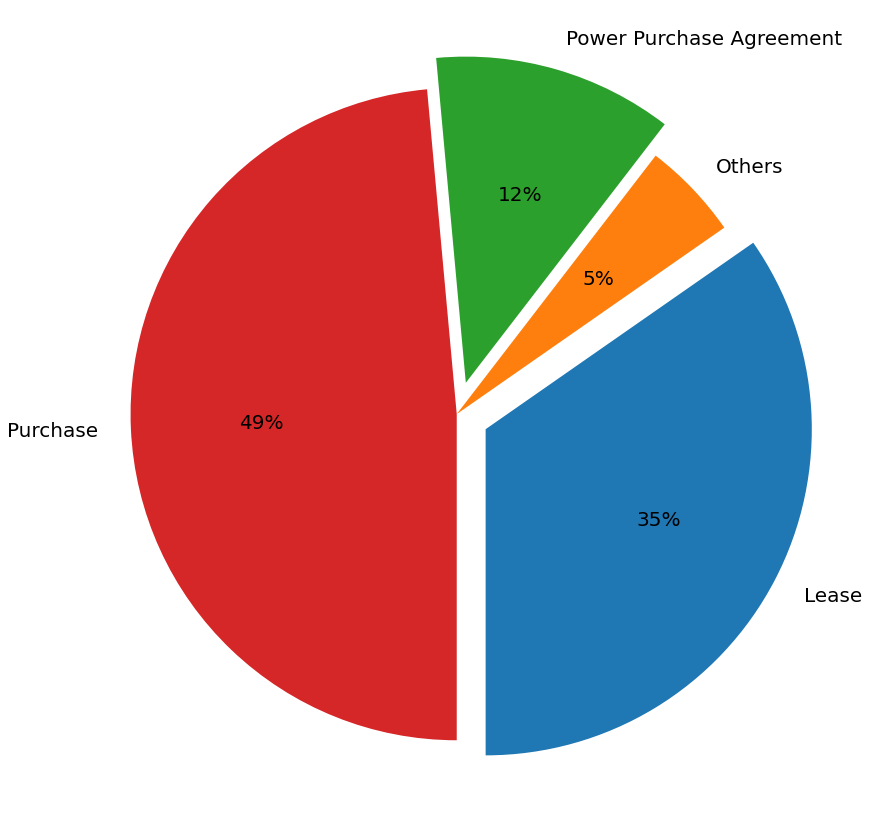

In [31]:
# Distribution of Purchase Type 
sql_statement = """SELECT PurchaseType AS pt,
    COUNT(ProjectID) AS IDS
    FROM Project 
    GROUP BY pt"""

df_PurchType=fetchResult(sql_statement)
fig = plt.figure(figsize=(15,15))
df_PurchType=df_PurchType.replace('nan','Others')
separated=(.1,0,0.1,0)
plt.pie(df_PurchType['IDS'].tolist(), labels=df_PurchType["pt"],
        autopct='%1.0f%%', shadow=False, startangle=270,explode=separated)
plt.rcParams['font.size'] = 20
plt.show()

Text(0.5, 1.0, 'Total Name Plate DC Change over the last year')

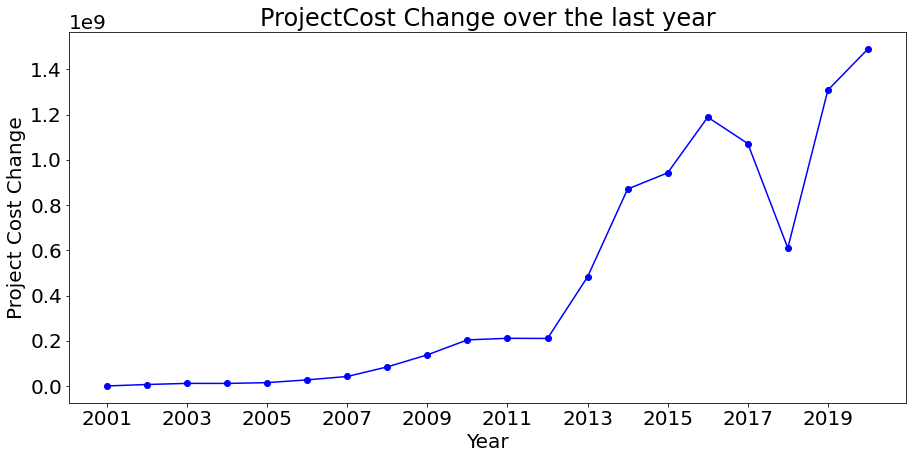

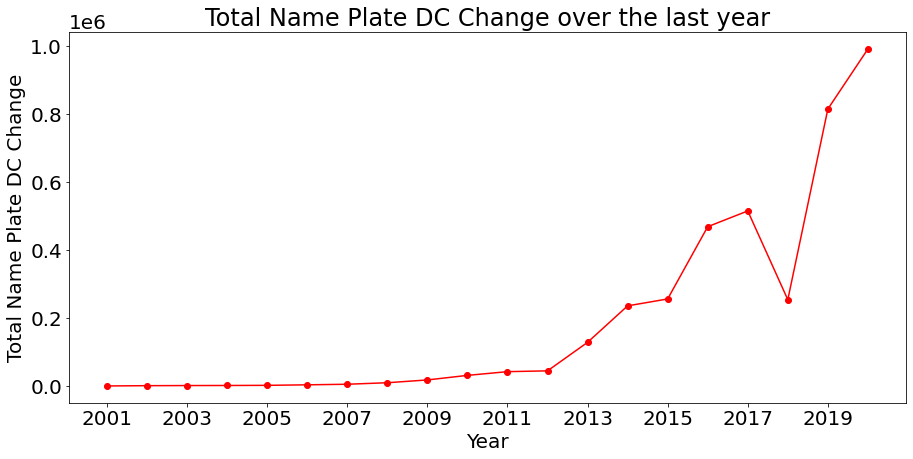

In [33]:
# Changes in the Project Cost and Total KwhDC generated
year=2020
x=[]
y=[]
year1=[]
for yr in range(2001,year+1):
    sql_statement = """SELECT SUM(ProjectCost) AS pc,
    SUM(TotNamePlateKWDC) AS DC_Capacity
    FROM ProjectCost INNER JOIN PROJECTPROD
    ON 
    PROJECTCOST.PROJECTID=PROJECTPROD.PROJECTID
    INNER JOIN ProjectTimeline AS pt
    ON
    pt.PROJECTID=PROJECTPROD.PROJECTID
    where cast(substr(pt.DtAppReceived,length(pt.DtAppReceived)-3,4) as INTEGER)<={0}"""
    
    sql_statement1="""SELECT SUM(ProjectCost) AS pc,
    SUM(TotNamePlateKWDC) AS DC_Capacity
    FROM ProjectCost INNER JOIN PROJECTPROD
    ON 
    PROJECTCOST.PROJECTID=PROJECTPROD.PROJECTID
    INNER JOIN ProjectTimeline AS pt
    ON
    pt.PROJECTID=PROJECTPROD.PROJECTID
    where cast(substr(pt.DtAppReceived,length(pt.DtAppReceived)-3,4) as INTEGER)<={0}"""
    sql_statement = sql_statement.format(yr)
    sql_statement1 = sql_statement1.format(yr-1)
    df_change_yr=fetchResult(sql_statement)
    df_change_yr1=fetchResult(sql_statement1)
    x.append(df_change_yr['pc']-df_change_yr1['pc'])
    y.append(df_change_yr['DC_Capacity']-df_change_yr1['DC_Capacity'])
    year1.append(yr)

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 1, 2)
plt.plot(year1, x, '-ok',color='Blue')
plt.xlabel('Year')
plt.xticks(np.arange(min(year1), max(year1)+1, 2.0))
plt.ylabel('Project Cost Change')
plt.title('ProjectCost Change over the last year')

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(year1,y, '-ok', color='Red')
plt.xticks(np.arange(min(year1), max(year1)+1, 2.0))
plt.xlabel('Year')
plt.ylabel('Total Name Plate DC Change')
plt.title('Total Name Plate DC Change over the last year')

In [34]:
# Top 15 Primary PV Manufacturer having the PV Modules Installed at various location of NY
sql_statement = """SELECT PriPVMft,COUNT(TotalPVQt) as pvqt FROM
                    PVModuleDetails
                    group by PriPVMft order by pvqt desc LIMIT 15"""

df_PriPVMft=fetchResult(sql_statement)
df_PriPVMft

,PriPVMft,pvqt
0,SunPower,14351
1,Trina Solar,12411
2,LG Electronics Inc.,7806
3,Hanwha Q CELLS,7095
4,Canadian Solar,6669
5,LG Electronics Solar Cell Division,6215
6,REC Solar,4941
7,Sunpower,4218
8,SolarWorld,4195
9,Others,3935


In [35]:
# Top 15 Primary Inverter Manufacturer having the Inverters Installed at various location of NY
sql_statement = """SELECT PriInvetMft,COUNT(TotalInvtQt) as invqt FROM
                    InverterDetails 
                    group by PriInvetMft order by invqt desc LIMIT 15"""

df_PriInvetMft=fetchResult(sql_statement)
df_PriInvetMft=df_PriInvetMft.drop(9)
df_PriInvetMft

,PriInvetMft,invqt
0,SolarEdge Technologies,17474
1,SMA America,13406
2,Enphase Energy,12928
3,SolarEdge Technologies Ltd.,11387
4,SunPower,10859
5,Enphase Energy Inc.,10640
6,ABB,10441
7,Power-One,4606
8,Fronius USA,4256
10,Enphase En,3066


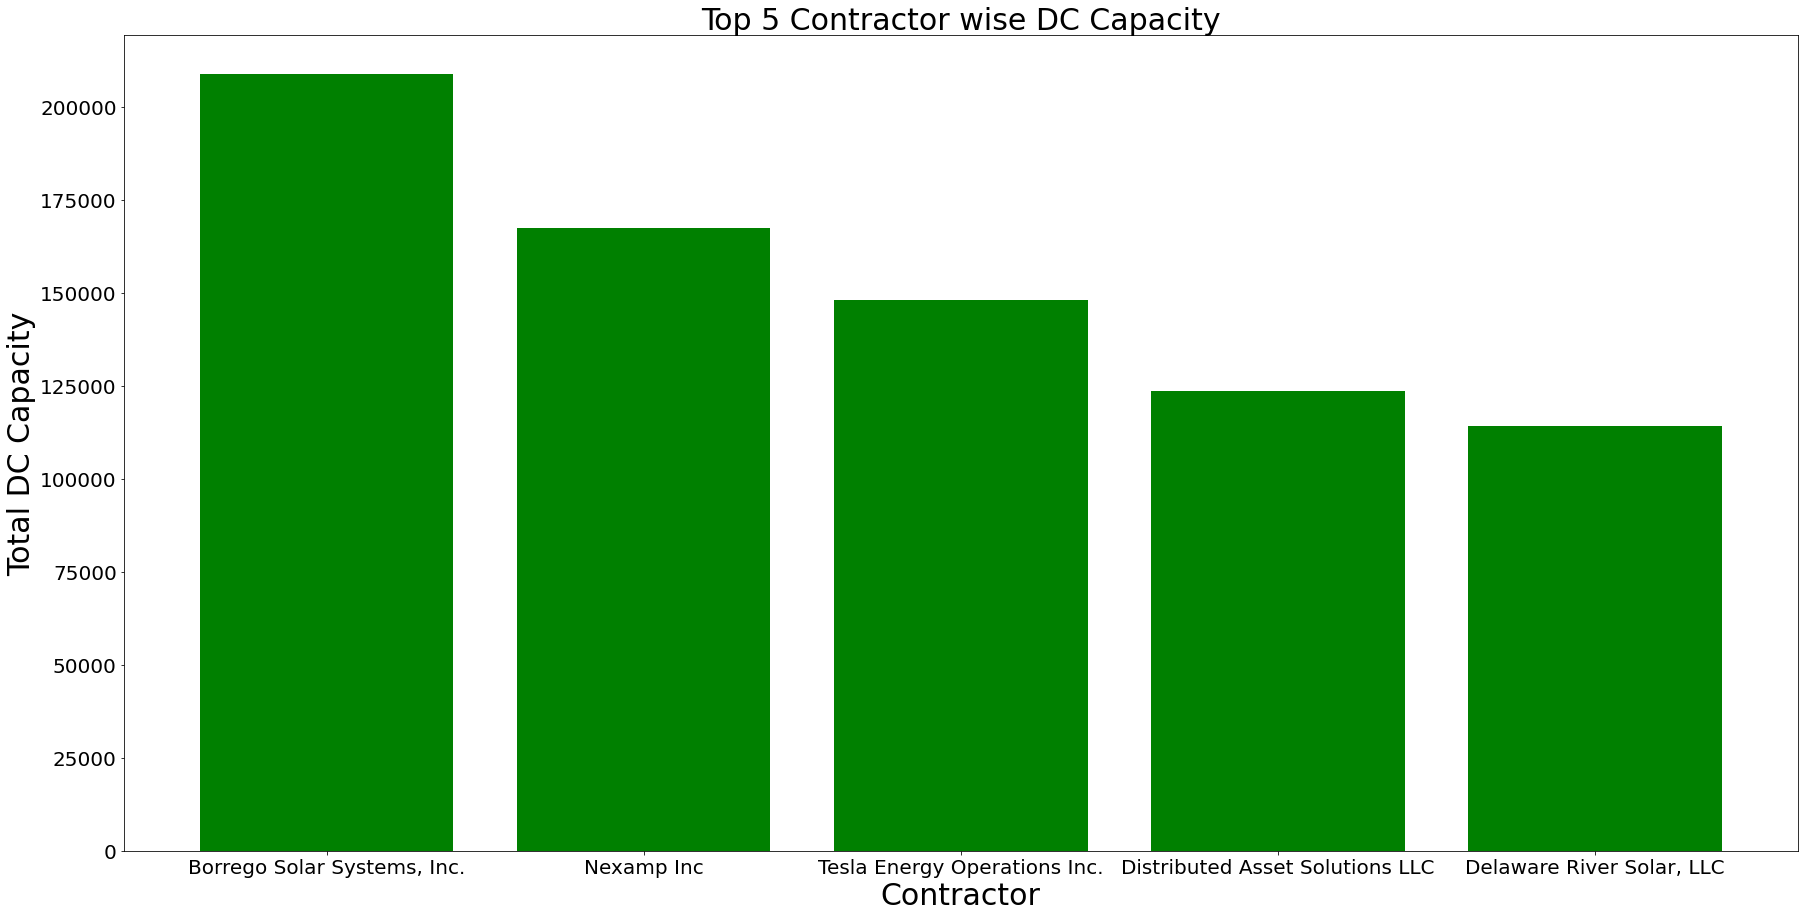

In [36]:
# Highest Solar Capacity Contractor
sql_statement = """SELECT SUM(TotNamePlateKWDC) as tot,Contractor FROM
                    ProjectProd INNER JOIN Project on 
                    Project.projectid=ProjectProd.projectid 
                    group by Contractor order by tot desc LIMIT 6"""

df_contract=fetchResult(sql_statement)
df_contract=df_contract.iloc[1:]
fig = plt.figure(figsize=(30,15))
plt.bar(df_contract['Contractor'],df_contract['tot'],color = 'green')
plt.xlabel('Contractor',fontsize = 30)
plt.ylabel('Total DC Capacity',fontsize = 30)
plt.title('Top 5 Contractor wise DC Capacity',fontsize = 30)
plt.show()

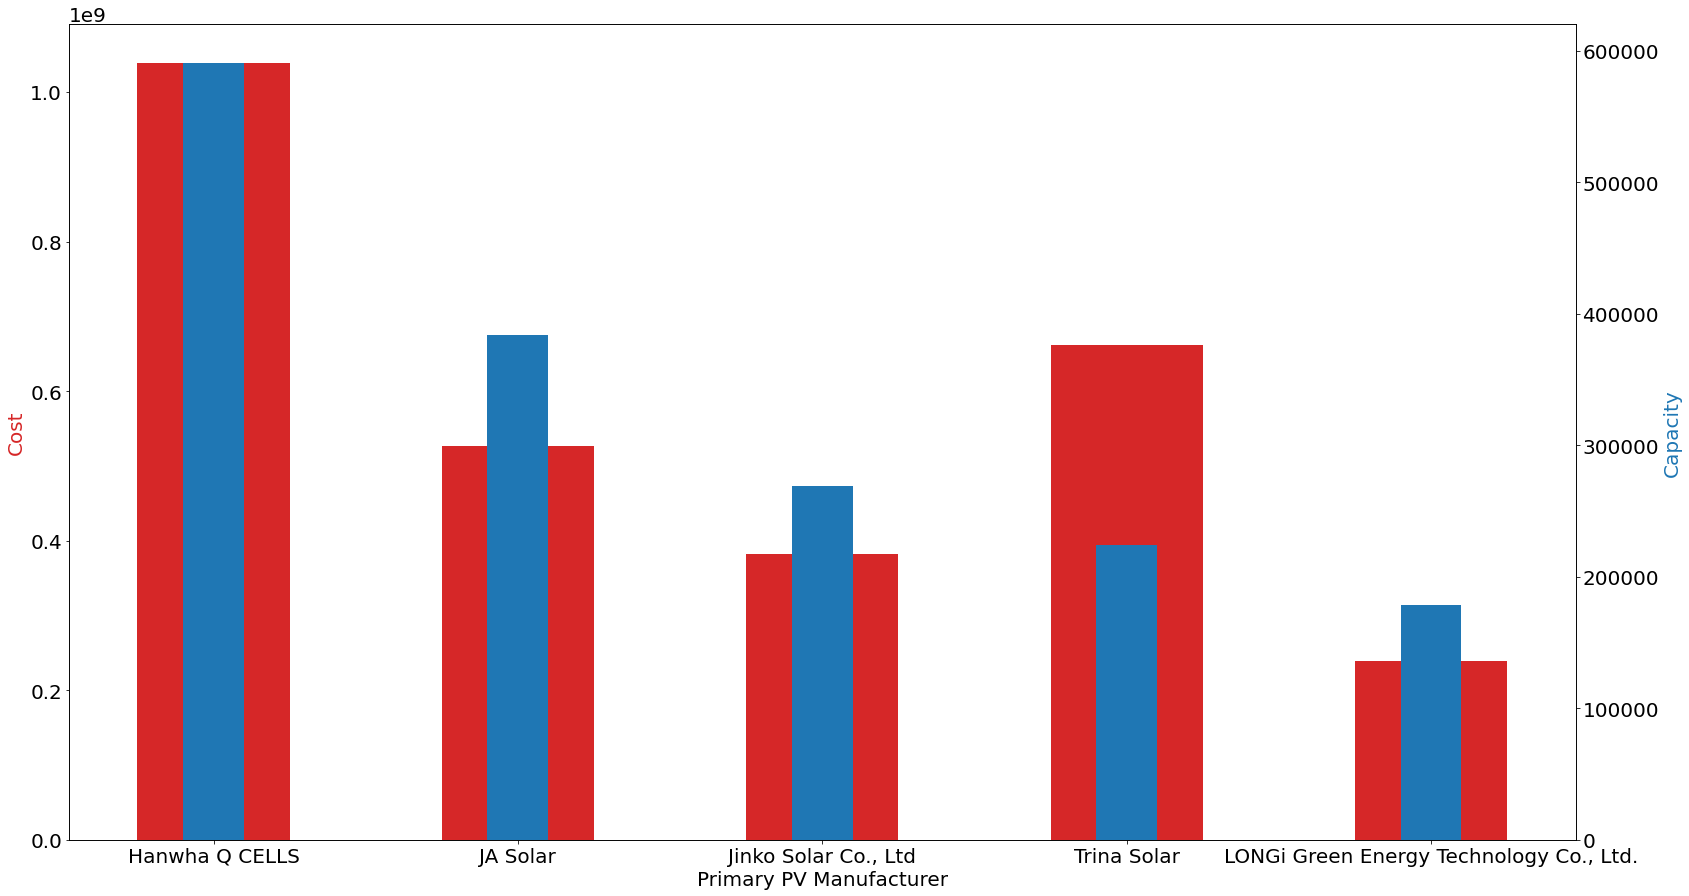

In [37]:
# PVModule Manufacturer having highest cumulative TotNamePlateKWDC with their cumulative cost
sql_statement = """SELECT SUM(TotNamePlateKWDC) as captot,SUM(ProjectCost) as costot,PriPVMft FROM
                    ProjectProd INNER JOIN ProjectCost on 
                    ProjectCost.projectid=ProjectProd.projectid 
                    INNER JOIN PVModuleDetails on
                    ProjectCost.projectid=PVModuleDetails.projectid 
                    group by PriPVMft order by captot desc LIMIT 6"""

df_PriPVMft=fetchResult(sql_statement)

df_PriPVMft=df_PriPVMft.drop(4)
t = df_PriPVMft['PriPVMft']
data1 = df_PriPVMft['costot']
data2 = df_PriPVMft['captot']

fig, ax1 = plt.subplots(figsize=(27,15))
barWidth = 0.2

color = 'tab:red'
ax1.set_xlabel('Primary PV Manufacturer')
ax1.set_ylabel('Cost', color=color)
ax1.bar(t, data1, width=barWidth+(0.3), color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Capacity', color=color)  # we already handled the x-label with ax1
ax2.bar(t, data2, width=barWidth, color=color)

plt.show()

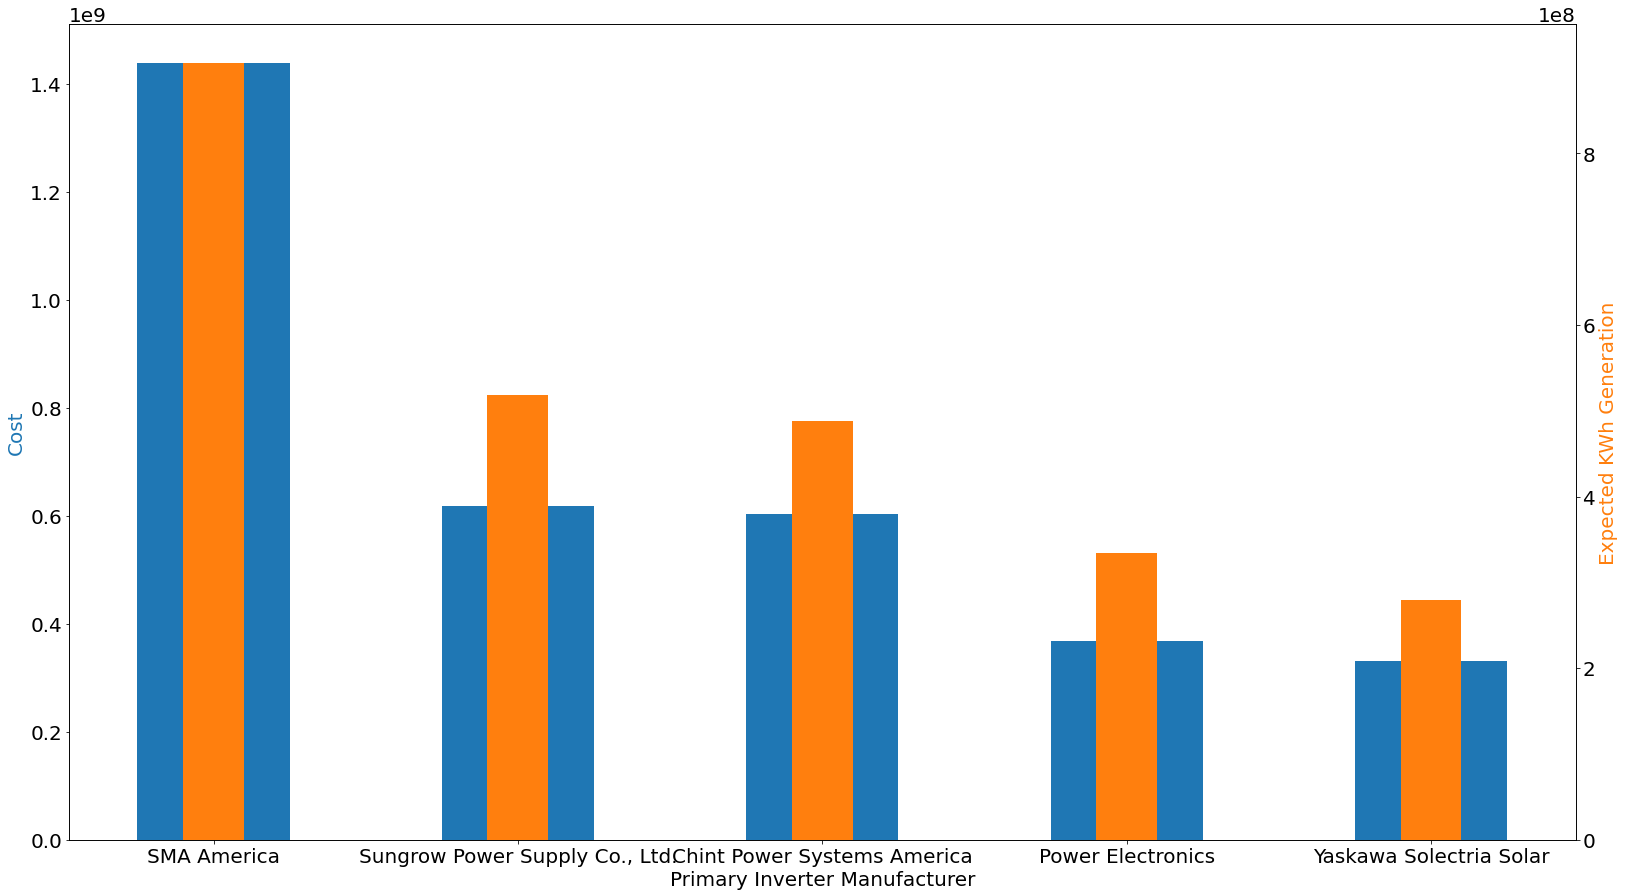

In [38]:
# PVModule Manufacturer having highest cumulative ExpectKWhAnnProd with their cumulative cost
sql_statement = """SELECT SUM(ExpectKWhAnnProd) as exptot,SUM(ProjectCost) as costot,PriInvetMft FROM
                    ProjectProd INNER JOIN ProjectCost on 
                    ProjectCost.projectid=ProjectProd.projectid 
                    INNER JOIN InverterDetails on
                    ProjectCost.projectid=InverterDetails.projectid 
                    group by PriInvetMft order by exptot desc LIMIT 5"""

df_PriInvetMft=fetchResult(sql_statement)

out = df_PriInvetMft['PriInvetMft']
data1 = df_PriInvetMft['costot']
data2 = df_PriInvetMft['exptot']

fig, ax1 = plt.subplots(figsize=(27,15))
barWidth = 0.2

color = 'tab:blue'
ax1.set_xlabel('Primary Inverter Manufacturer')
ax1.set_ylabel('Cost', color=color)
ax1.bar(out, data1, width=barWidth+(0.3), color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Expected KWh Generation', color=color)  # we already handled the x-label with ax1
ax2.bar(out, data2, width=barWidth, color=color)

plt.show()

In [39]:
# Highest Solar Producing projects with city popup in each county
sql_statement = """SELECT MAX(TotNamePlateKWDC),ProjectProd.ProjectID, City, County, Location FROM
                    ProjectProd INNER JOIN ProjectLocation on 
                    ProjectProd.projectid=ProjectLocation.projectid 
                    INNER JOIN ProjectCost
                    ON ProjectProd.projectid=ProjectCost.projectid
                    group by County order by TotNamePlateKWDC desc """

df_projects=fetchResult(sql_statement)
ll2=df_projects['Location'].tolist()

ll1=[]
ll3=df_projects['City'].tolist()
for ele in ll2:
    ele=ele.strip('()')
    a=ele.split(',')
    a[1]=a[1].strip()
    ll1.append(a)

map = folium.Map(location=ll1[25], zoom_start=6.5)
i=0
k=0
for k in range(0,len(ll1)):
    folium.Marker(location = [ll1[k][0], ll1[k][1]],
    popup = ll3[k],
    icon = folium.Icon(color = 'orange')).add_to(map)
    k+=1
map

In [40]:
# Highest GreenCertified, RemNetMet, AffSolar, CommDistGener Solar Producing projects with city popup in each county
sql_statement = """SELECT MAX(TotNamePlateKWDC),ProjectProd.ProjectID,GreenCertified, City, Location FROM
                    ProjectProd INNER JOIN ProjectLocation on 
                    ProjectProd.projectid=ProjectLocation.projectid 
                    INNER JOIN ProjectCost
                    ON ProjectProd.projectid=ProjectCost.projectid where GreenCertified='Yes'
                    group by County order by TotNamePlateKWDC desc LIMIT 10"""

sql_statement1 = """SELECT MAX(TotNamePlateKWDC),ProjectProd.ProjectID,RemNetMet, City, Location FROM
                    ProjectProd INNER JOIN ProjectLocation on 
                    ProjectProd.projectid=ProjectLocation.projectid 
                    INNER JOIN ProjectCost
                    ON ProjectProd.projectid=ProjectCost.projectid where RemNetMet='Yes'
                    group by County order by TotNamePlateKWDC desc LIMIT 10"""

sql_statement2 = """SELECT MAX(TotNamePlateKWDC),ProjectProd.ProjectID,AffSolar, City, Location FROM
                    ProjectProd INNER JOIN ProjectLocation on 
                    ProjectProd.projectid=ProjectLocation.projectid 
                    INNER JOIN ProjectCost
                    ON ProjectProd.projectid=ProjectCost.projectid where AffSolar='Yes'
                    group by County order by TotNamePlateKWDC desc LIMIT 10"""

sql_statement3 = """SELECT MAX(TotNamePlateKWDC),ProjectProd.ProjectID,CommDistGener, City, Location FROM
                    ProjectProd INNER JOIN ProjectLocation on 
                    ProjectProd.projectid=ProjectLocation.projectid 
                    INNER JOIN ProjectCost
                    ON ProjectProd.projectid=ProjectCost.projectid where CommDistGener='Yes'
                    group by County order by TotNamePlateKWDC desc LIMIT 10"""
    
    
def df_project_manipulate(df_projects):   
    ll2=[]
    ll2=df_projects['Location'].tolist()
    ll1=[]
    ll3=df_projects['City'].tolist()
    for ele in ll2:
        ele=ele.strip('()')
        a=ele.split(',')
        a[1]=a[1].strip()
        ll1.append(a)
    return ll1,ll3

ll_gc,ll_gc_name=df_project_manipulate(fetchResult(sql_statement))
ll_rmnmt,ll_rmnmt_name=df_project_manipulate(fetchResult(sql_statement1))
ll_as,ll_as_name=df_project_manipulate(fetchResult(sql_statement2))
ll_ss,ll_ss_name=df_project_manipulate(fetchResult(sql_statement3))

map = folium.Map(location=ll_gc[4], zoom_start=6.5)
def map_maker(ll_map,ll_map1,col):
    for k in range(0,len(ll_map)):
        folium.Marker(location = [ll_map[k][0], ll_map[k][1]],
        popup = ll_map1[k],
        icon = folium.Icon(color = col)).add_to(map)
map_maker(ll_gc,ll_gc_name,'green')
map_maker(ll_rmnmt,ll_rmnmt_name,'gray')
map_maker(ll_as,ll_as_name,'blue')
map_maker(ll_ss,ll_ss_name,'red')
map

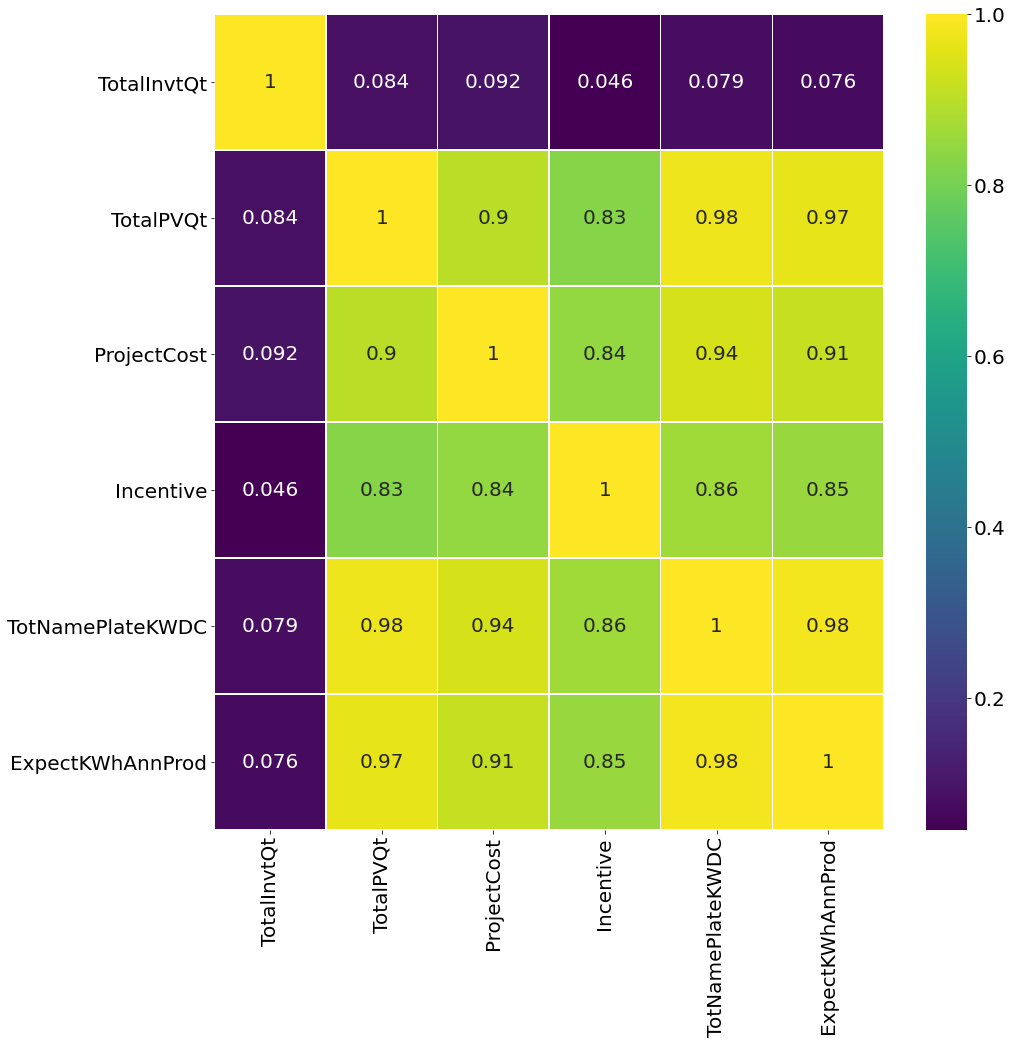

In [41]:
# Correlation Matrix
sql_statement = """SELECT TotalInvtQt, TotalPVQt, ProjectCost, Incentive, TotNamePlateKWDC,ExpectKWhAnnProd,TotalDays
                    FROM PVModuleDetails INNER JOIN InverterDetails 
                    on 
                    PVModuleDetails.ProjectID=InverterDetails.ProjectID
                    INNER JOIN ProjectCost 
                    on
                    ProjectCost.ProjectID=PVModuleDetails.ProjectID
                    INNER JOIN ProjectProd
                    on 
                    ProjectProd.ProjectID=ProjectCost.ProjectID
                    INNER JOIN ProjectTimeline
                    on ProjectTimeline.ProjectID=ProjectProd.ProjectID"""

df_corr=fetchResult(sql_statement)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_corr.corr(), annot=True ,cmap='viridis' ,linewidths=.5, ax=ax)

 - - - 
TOTAL KW SOLAR UP TO 2020: 
3.824272
 - - - 
Mean Absolute Error: 0.17109767729885209
Mean Squared Error: 0.031405305480138944
Root Mean Squared Error: 0.1772154211126643
[3.03111829 3.26486227 3.49860625 3.73235023 3.96609421 4.19983819
 4.43358217 4.66732615 4.90107013 5.13481411 5.36855809]


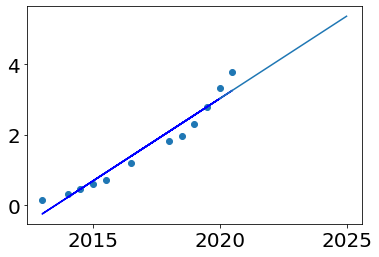

In [47]:
# LINEAR REGRESSION BY YEAR/MID YEAR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib

def KW_date_status():
    sql_statement="""select pp.totNamePlateKWDC, SUBSTR(pt.DtAppReceived, -4) AS dtapp, SUBSTR(pt.DtAppReceived, 1, 2) AS mon, p.ProjectStatus from 
            ProjectTimeline AS pt 
            INNER JOIN 
            ProjectProd AS pp
            on pt.ProjectID=pp.ProjectID
            INNER JOIN
            Project AS p
            on pt.ProjectID=p.ProjectID order by dtapp ASC"""
    
    normalized_database_filename = 'normalized.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df = pd.read_sql_query(sql_statement, conn)
    df = df.dropna()
    df = df.replace('','0')
    return df

#Pull from DB
df = KW_date_status() 
kwdc = df['TotNamePlateKWDC']
dar = df['dtapp'] #yr app received
mon = df['mon']   #month of the year
df = df[df['ProjectStatus'] == 'Complete'] 
#dfpipe = df[df['ProjectStatus'] == 'Pipeline'] 

#Begin totalling kw
kw = []
for ele in kwdc:
    e = round(float(ele))
    kw.append(int(e))
sumkW = 0
for ele in kw:
    sumkW += ele
totkWsolar = sumkW/1000000
print(' - - - ')
print('TOTAL KW SOLAR UP TO 2020: ')
print(totkWsolar) 
print(' - - - ')

#Begin grouping kw totals by year/(midyear)
years = []
midyears = []
kws = []
kwsmid = []

for i in range(0,len(dar)):
    if not int(dar[i]) in years and int(mon[i]) < 7 and int(dar[i]) != 2000:
        years.append(int(dar[i]))
        kws.append(kw[i])
    elif not int(dar[i]) in midyears and int(mon[i]) >= 7 and int(dar[i]) != 2000:
        midyears.append(int(dar[i]))
        kwsmid.append(kw[i])
    elif int(mon[i]) < 7 and int(dar[i]) != 2000:
        kws[len(kws)-1] += kw[i]
    elif int(mon[i]) >= 7 and int(dar[i]) != 2000:
        kwsmid[len(kwsmid)-1] += kw[i]
   
#Begin separating 2000-2010 from 2011-2020 (Most Solar Prod ramps up after 2010)
X = []
missX = []
y = []
missy = []
tot1 = 0
for i in range(0,11):
    missX.append(years[i])
    missX.append(midyears[i] + .5)
    tot1 += kws[i]
    tot1 += kwsmid[i]
    missy.append(tot1)
tot2 = tot1

for i in range(12,20):
    X.append(years[i])
    X.append(midyears[i] + .5)
    tot2 += kws[i]
    y.append(tot2)
    tot2 += kwsmid[i]
    y.append(tot2)

#Divide by 1,000,000 to convert kw to gw
newy = []
for ele in y:
    newy.append(ele/1000000)
y = newy


#Begin to make a prediction
d = {'Year':X,'TotalKW':y}
df = pd.DataFrame(d)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
dfp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

#Print Model Accuracy
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#Plot
plt.scatter(X_train, y_train)
plt.plot(X_train, regressor.predict(X_train), color = "blue")

#Predict the future
future = pd.DataFrame([2020,2020.5,2021,2021.5,2022,2022.5,2023,2023.5,2024,2024.5,2025])
print(regressor.predict(future))
rpf = regressor.predict(future)
plt.plot(future, regressor.predict(future))

# Prediction for 2025: 5.37
# Problem: only 16 data points. Must split months even further than by midpoint.

In [ ]:
# FB PROPHET
from fbprophet import Prophet
from pandas import to_datetime
import datetime
import numpy 
import pandas
from matplotlib import pyplot

def KW_by_every_month():
    sql_statement="""select pt.DtAppReceived as ds, pp.totNamePlateKWDC as y, SUBSTR(pt.DtAppReceived, -4) AS dtapp, SUBSTR(pt.DtAppReceived, 1, 2) AS mm, SUBSTR(pt.DtAppReceived, 4, 2) AS dd, p.ProjectStatus from 
            ProjectTimeline AS pt 
            INNER JOIN 
            ProjectProd AS pp
            on pt.ProjectID=pp.ProjectID
            INNER JOIN
            Project AS p
            on pt.ProjectID=p.ProjectID order by dtapp ASC, mm ASC, dd ASC"""
    
    normalized_database_filename = 'normalized.db'
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df = pd.read_sql_query(sql_statement, conn)
    df = df.dropna()
    df = df.replace('','0')
    return df
df = KW_by_every_month()
#df = df.iloc[2:] #remove top 2 entries for year 2000
#df = df.drop(df.tail(2).index,inplace=True) #drop last two NA entries
#display(df['ds'])

df['ds'] = df['dtapp'] + '-' + df['mm'] + '-' + df['dd']

df = df.drop(['dtapp', 'mm', 'dd', 'ProjectStatus'], axis=1)

df['ds'] = pd.to_datetime(df['ds'])
df['y'] = pandas.to_numeric(df['y'])

kwTotal = []
total = 0
for ele in df['y']:
    total+=ele
    kwTotal.append(total/1000000)
    
df['y'] = pd.DataFrame(kwTotal)
display(df['y'].tail())

#print(df)
#print(df.dtypes)

print('MODEL FIT LOADING...')
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365*5) 
pred = model.predict(future)
print('DONE!')

display(pred.head())
display(pred.tail())

#model.plot(pred)
#Next Cell

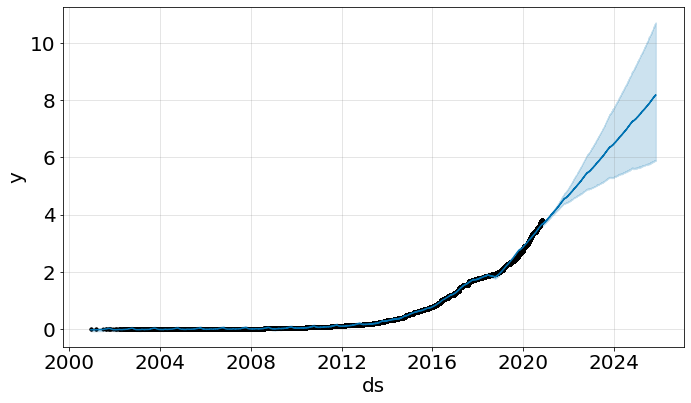

In [59]:
# View the fbProphet prediction
fig = model.plot(pred)

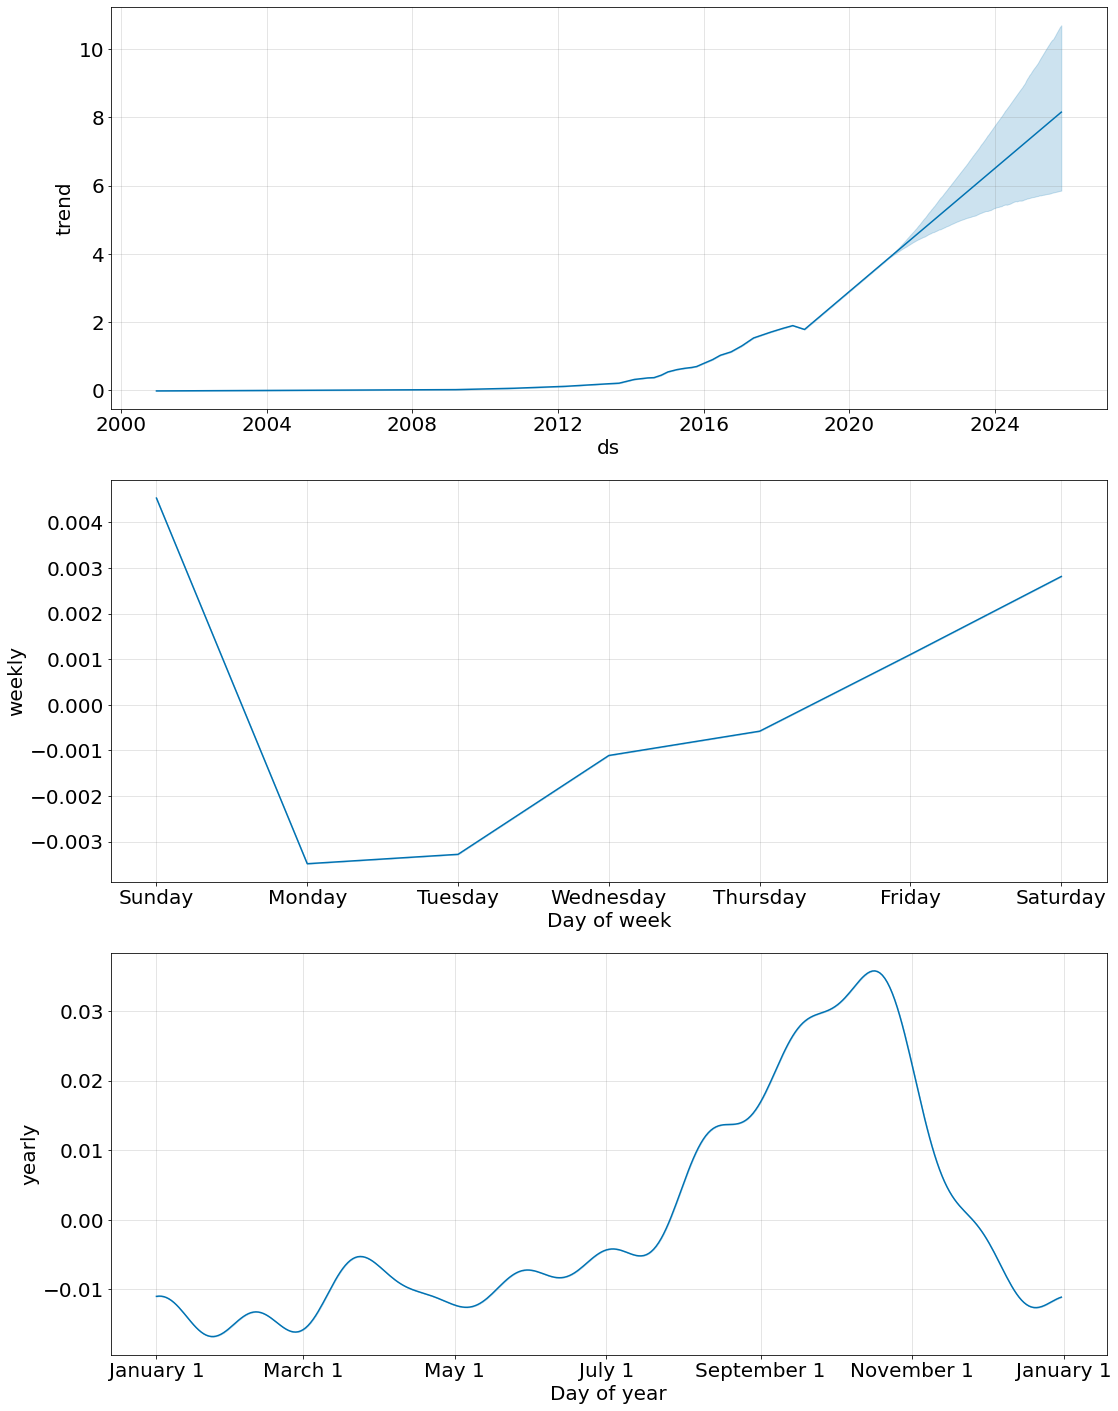

In [60]:
# Visualize Each Component of fbProphet
figs = model.plot_components(pred, figsize=(16,20))

In [61]:
# Cross-Validation (WARNING: Running this will take about 45 minutes!)

# We specify the forecast horizon (horizon), and then optionally the size of 
# the initial training period (initial) and the spacing between cutoff dates (period). 
# By default, the initial training period is set to three times the horizon, 
# and cutoffs are made every half a horizon.

from fbprophet.diagnostics import cross_validation
cv = cross_validation(model, period='365 days', horizon = '730 days')
cv.head()

INFO:fbprophet:Making 12 forecasts with cutoffs between 2007-11-03 00:00:00 and 2018-10-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2007-11-06,0.013016,0.012969,0.013068,0.012938,2007-11-03
1,2007-11-06,0.013016,0.012966,0.013070,0.012942,2007-11-03
2,2007-11-06,0.013016,0.012968,0.013065,0.012934,2007-11-03
3,2007-11-07,0.013033,0.012981,0.013086,0.012947,2007-11-03
4,2007-11-07,0.013033,0.012986,0.013084,0.012958,2007-11-03


In [62]:
# Performance Metrics
from fbprophet.diagnostics import performance_metrics
p = performance_metrics(cv)
display(p.head())
display(p.tail())

,horizon,mse,rmse,mae,mape,mdape,coverage
0,78 days,0.000708,0.026611,0.020638,0.027881,0.023284,0.122495
1,79 days,0.000715,0.026740,0.020770,0.027959,0.023380,0.120415
2,80 days,0.000717,0.026774,0.020829,0.028093,0.023280,0.118841
3,81 days,0.000715,0.026733,0.020816,0.028247,0.023362,0.114172
4,82 days,0.000714,0.026717,0.020887,0.028636,0.023432,0.101569


,horizon,mse,rmse,mae,mape,mdape,coverage
648,726 days,0.187775,0.433330,0.312855,0.261958,0.263079,0.220084
649,727 days,0.183871,0.428801,0.308959,0.263328,0.263429,0.212560
650,728 days,0.188231,0.433856,0.312741,0.263296,0.263294,0.217433
651,729 days,0.188548,0.434221,0.312847,0.263093,0.263354,0.224165
652,730 days,0.186964,0.432393,0.311290,0.262945,0.263707,0.228196


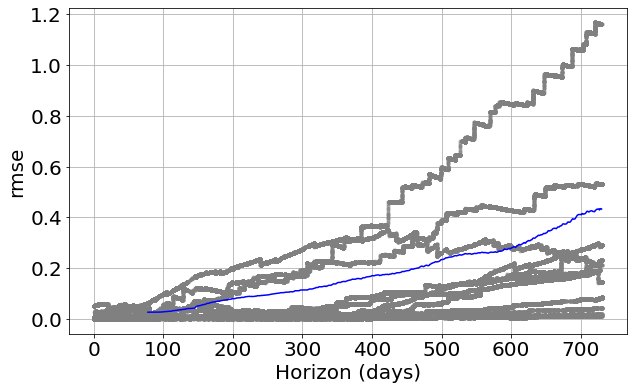

In [63]:
# Cross-Validation Performance Metrics Root Mean Squared Error Plot
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv, metric='rmse')